<a href="https://colab.research.google.com/github/yasharmaster/image-segmentation-demo/blob/master/Ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Common Setup

In [0]:
#@title Imports

import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec, patches
import numpy as np
from PIL import Image

import tensorflow as tf
from matplotlib.patches import Polygon

import sys
import random
import math
import skimage.io
import matplotlib
import matplotlib.pyplot as plt


#DeepLab v3 Setup

In [0]:
#@title Helper methods


class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map

CLASS_NAMES_DEEPLAB = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

In [4]:
#@title Select and download models {display-mode: "form"}

MODEL_NAME = 'mobilenetv2_coco_voctrainaug'  # @param ['mobilenetv2_coco_voctrainaug', 'mobilenetv2_coco_voctrainval', 'xception_coco_voctrainaug', 'xception_coco_voctrainval']

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


# Mask RCNN Setup

In [5]:
!git clone https://github.com/matterport/Mask_RCNN
os.chdir('./Mask_RCNN')
!git checkout 1ad9feaae3d87b52495413e6c8ea0e92f0e5bc34
!pip install -r requirements.txt
!python setup.py install
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.1/mask_rcnn_balloon.h5

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 119.72 MiB | 10.83 MiB/s, done.
Resolving deltas: 100% (549/549), done.
Note: checking out '1ad9feaae3d87b52495413e6c8ea0e92f0e5bc34'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 1ad9fea Multiple Anchors have same IOU
    100% |████████████████████████████████| 204kB 24.6MB/s 
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.

In [6]:
# Root directory of the project
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
CLASS_NAMES_MASKRCNN = ['background', 'person', 'bicycle', 'car', 'motorcycle', 'aeroplane',
                 'bus', 'train', 'truck', 'boat', 'traffic light',
                 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
                 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
                 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
                 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
                 'kite', 'baseball bat', 'baseball glove', 'skateboard',
                 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
                 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
                 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
                 'donut', 'cake', 'chair', 'couch', 'pottedplant', 'bed',
                 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
                 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
                 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
                 'teddy bear', 'hair drier', 'toothbrush']

Using TensorFlow backend.


... done downloading pretrained model!

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE

In [0]:
def get_color_dict():
  all_colors = visualize.random_colors(100)
  color_dict = {}
  i = 0
  for c in CLASS_NAMES_DEEPLAB:
    color_dict[c] = all_colors[i]
    i = i+1
  for c in CLASS_NAMES_MASKRCNN:
    if not c in color_dict:
      color_dict[c] = all_colors[i]
      i = i+1
  return color_dict

COLOR_MAP = get_color_dict()

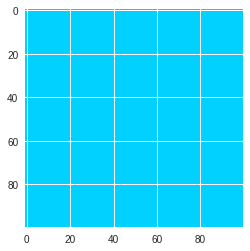

In [13]:
bg_color = np.array(COLOR_MAP[CLASS_NAMES_DEEPLAB[0]])
seg_map = np.full([100, 100, 3], bg_color)
plt.imshow(seg_map)

In [0]:
def PIL2array(img):
    return np.array(img.getdata(),
                    np.uint8).reshape(img.size[1], img.size[0], 3)

def label_to_color_image(labels, deeplab):
  # Adds color defined by the dataset colormap to the label.
  h,w = labels.shape
  img = np.zeros([h,w,3])
  img = np.zeros((h,w),dtype=(float,3))
  for i in range(h):
    for j in range(w):
      if deeplab:
        img[i][j] = np.array(COLOR_MAP[CLASS_NAMES_DEEPLAB[labels[i][j]]])
      else:
        img[i][j] = np.array(COLOR_MAP[CLASS_NAMES_MASKRCNN[labels[i][j]]])        
  img = img*255
  return img.astype(np.uint8)


def get_seg_image(img, result):
  boxes = result['rois']
  masks = result['masks']
  class_ids = result['class_ids']
  
  N = boxes.shape[0]
  h,w,c = img.shape
  seg_map = np.zeros((h,w))
  for i in range(N):
    mask = masks[:, :, i]
    mask = mask.astype(np.uint8)
    print(mask)
    print(class_ids[i])
    seg_map = seg_map + mask*class_ids[i]
  
  return label_to_color_image(seg_map.astype(np.uint8), False)


def run_visualization(url):
  """Inferences DeepLab model and visualizes result."""
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    original_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  # DeepLab
  resized_im, labels = MODEL.run(original_im)
  seg_map_deeplab = label_to_color_image(labels, True)
  img = PIL2array(resized_im)

  # Mask RCNN
  results = model.detect([img], verbose=0)
  r = results[0]
  seg_map_maskrcnn = get_seg_image(img, r)
  print(seg_map_maskrcnn[0][0])
  visualize.display_images([img, seg_map_deeplab, seg_map_maskrcnn], ["original", "DeepLab v3", "Mask RCNN"])


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
1
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
2
[  0 209 255]


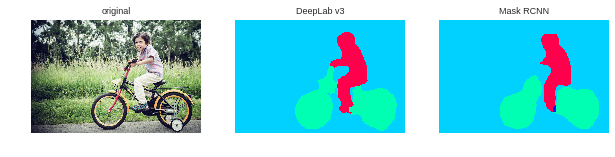

In [37]:
#@title Run on sample images {display-mode: "form"}

SAMPLE_IMAGE = 'image1'  # @param ['image1', 'image2', 'image3']
IMAGE_URL = ''  #@param {type:"string"}

_SAMPLE_URL = ('https://github.com/tensorflow/models/blob/master/research/'
               'deeplab/g3doc/img/%s.jpg?raw=true')

image_url = IMAGE_URL or _SAMPLE_URL % SAMPLE_IMAGE
run_visualization(image_url)